딥드림

In [4]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 17s 0us/step


In [5]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5
}

In [6]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.)
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [7]:
dream = model.input
grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_value = outs[1]
    return loss_value, grad_value

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
        x += step * grad_values
    return x

In [8]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [9]:
import numpy as np

step = 0.01  
num_octave = 3  
octave_scale = 1.4  
iterations = 20 
max_loss = 10.

base_image_path = './original_photo_deep_dream.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='./final_dream.png')

처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.6596164
... 1 번째 손실 : 1.0168362
... 2 번째 손실 : 1.4648265
... 3 번째 손실 : 2.0113597
... 4 번째 손실 : 2.5789797
... 5 번째 손실 : 3.1369202
... 6 번째 손실 : 3.720512
... 7 번째 손실 : 4.124297
... 8 번째 손실 : 4.564449
... 9 번째 손실 : 4.9819846
... 10 번째 손실 : 5.431282
... 11 번째 손실 : 5.8327675
... 12 번째 손실 : 6.275667
... 13 번째 손실 : 6.6098957
... 14 번째 손실 : 6.9943314
... 15 번째 손실 : 7.412149
... 16 번째 손실 : 7.6775208
... 17 번째 손실 : 8.138262
... 18 번째 손실 : 8.52269
... 19 번째 손실 : 8.890452
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 2.1729467
... 1 번째 손실 : 3.6056104
... 2 번째 손실 : 4.737274
... 3 번째 손실 : 5.6521597
... 4 번째 손실 : 6.5305867
... 5 번째 손실 : 7.3693094
... 6 번째 손실 : 8.050576
... 7 번째 손실 : 8.677867
... 8 번째 손실 : 9.5533905
처리할 이미지 크기 (350, 350)
... 0 번째 손실 : 2.3857784
... 1 번째 손실 : 3.7081025
... 2 번째 손실 : 5.0353885
... 3 번째 손실 : 6.548676
... 4 번째 손실 : 8.877169


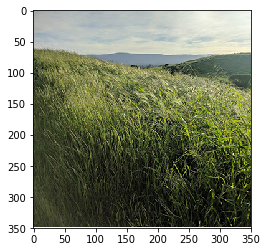

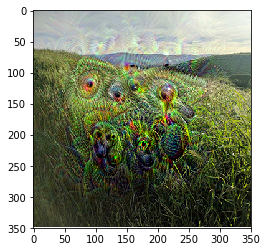

In [11]:
from matplotlib import pyplot as plt

plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

In [12]:
from keras.preprocessing.image import load_img, img_to_array, save_img

target_image_path = './portrait.png'
style_reference_image_path = './popova.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [13]:
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('모델 로드 완료.')

80142336/80134624 [==============================] - 46s 1us/step
모델 로드 완료.


In [15]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [16]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [17]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [18]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [19]:
grads = K.gradients(loss, combination_image)[0]

# 현재 손실과 그래디언트의 값을 추출하는 케라스 Function 객체입니다
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [20]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

# 뉴럴 스타일 트랜스퍼의 손실을 최소화하기 위해 생성된 이미지에 대해 L-BFGS 최적화를 수행합니다
# 초기 값은 타깃 이미지입니다
# scipy.optimize.fmin_l_bfgs_b 함수가 벡터만 처리할 수 있기 때문에 이미지를 펼칩니다.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('현재 손실 값:', min_val)
    # 생성된 현재 이미지를 저장합니다
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


반복 횟수: 0
현재 손실 값: 8180237000.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 5s
반복 횟수: 1
현재 손실 값: 3309749500.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 2s
반복 횟수: 2
현재 손실 값: 2114856700.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 2s
반복 횟수: 3
현재 손실 값: 1559858800.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 2s
반복 횟수: 4
현재 손실 값: 1275463600.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 2s
반복 횟수: 5
현재 손실 값: 1102424200.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 2s
반복 횟수: 6
현재 손실 값: 993483600.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 2s
반복 횟수: 7
현재 손실 값: 895521150.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 2s
반복 횟수: 8
현재 손실 값: 827708500.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 2s
반복 횟수: 9
현재 손실 값: 770512200.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 2s
반복 횟수: 10
현재 손실 값: 727949760.0
저장 이미지:  styl

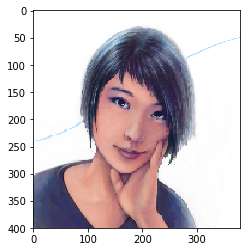

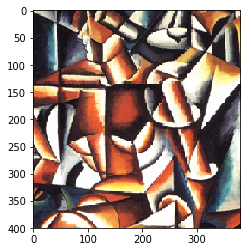

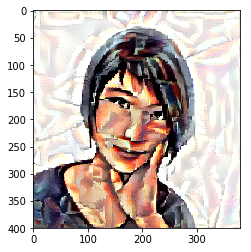

In [21]:
from matplotlib import pyplot as plt

plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(img)
plt.show()